# Pointwise Mutual Information (PMI)

Definition:

`PMI(w1, w2) = log(P(w1, w2)/P(w1)*P(w2)) = log(P(w2|w1)/P(w2)) = log(P(w1|w2)/P(w1))`

Properties:

 - `PMI(w1, w2) = 0`  iff w1 and w2 are independent (since `PMI(w1, w2) = 0` iff `P(w1, w2) = P(w1)*P(w2)`)
 - `PMI(w1, w2) < 0`iff w1 and w2 occur more frequently in separation than together
 - Symmetric (`PMI(w1, w2) = PMI(w2, w1)` since `P(w1, w2) = P(w1w2) + P(w2w1)` (and by the symmetry of information)

## Read Data & Preprocess

 - read CSV
 - set which columns are textual
 - remove empty and put in list data structure

In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [2]:
obj_tbl = pd.read_csv("../data/tables/Objects.csv.gz")
str_cols = "Title", "Description"

In [3]:
all_txts = [s for col in str_cols for s in obj_tbl[col].dropna()]  # maybe: random permutation
tokens = [w for txt in all_txts for w in txt.split()]

print("number of tokens: ", len(tokens))
print("number of types: ", len(set(tokens)))
print("TTR: ", len(set(tokens))/len(tokens))

number of tokens:  274580
number of types:  43518
TTR:  0.15848932915725836


## CountVectorise

 - get unigram counts -- remove stopwords
 - get bigrams counts -- remove stopwords

NOTE:  
one CountVectoriser for both unigrams and bigrams yields the same result as two -- one for each  

 
CAUTION:  
cannot give the unigram vocabulary to the bigram CountVectoriser, since that vocabulary needs to already consist of bigrams; taking the entire Cartesian product of the unigram vocabulary is not an option, since it would be too large  
=> possible solution: CountVectoriser also accepts a mapping 


CAUTION:  
the unigram vocab constructed from the bigram.vocab will not contain types from unigram.vocab (less than 0.3 percent)  
-> this is mainly because some types are titles and hence do not occur in any bigrams  
-> IGNORE

OBSERVATION:  
the unigram vocabulary is a proper superset of the bigram vocabulary  
=> this way around is okay, the other way around would be problematic since it would leave PMI undefined

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

import nltk
stopwords = nltk.corpus.stopwords.words('dutch')

cv_params = dict(strip_accents="unicode", lowercase=True, 
                 max_df=1., min_df=0., max_features=None,
                stop_words=stopwords)


unigram_cv = CountVectorizer(ngram_range=(1, 1), **cv_params)
uni_cs = unigram_cv.fit_transform(all_txts)

bigram_cv = CountVectorizer(ngram_range=(2, 2), **cv_params)  #  vocabulary=unigram_cv.vocabulary_,
bi_cs = bigram_cv.fit_transform(all_txts)
uni_cs.shape, bi_cs.shape

((11199, 27004), (11199, 94456))

In [8]:
bi_uni = {w for bi in bigram_cv.vocabulary_.keys() for w in bi.split()}
uni = unigram_cv.vocabulary_.keys()

len(uni-bi_uni)

287

In [9]:
uni_freqs = {w: uni_cs.T[i].sum() for w, i in tqdm(unigram_cv.vocabulary_.items())}


100%|██████████| 27004/27004 [00:48<00:00, 551.47it/s]


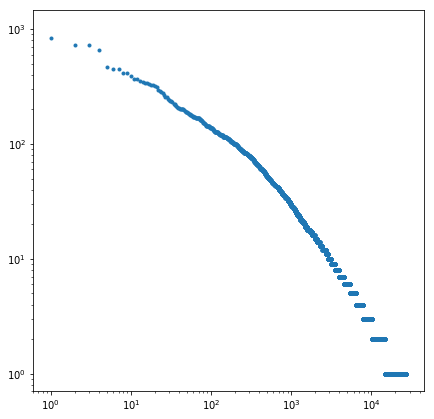

In [15]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")

# sns.histplot(uni_freqs.values())

rs = list(range(len(uni_freqs)))
          
plt.plot(rs, sorted(uni_freqs.values(), reverse=True), ".")

In [16]:
sorted(uni_freqs.items(), key=lambda tup: tup[1], reverse=True)[:100]

[('the', 1027),
 ('werden', 829),
 ('gebruikt', 734),
 ('gemaakt', 732),
 ('twee', 662),
 ('houten', 464),
 ('tijdens', 446),
 ('and', 445),
 ('aardewerk', 417),
 ('grote', 412),
 ('wit', 391),
 ('vorm', 369),
 ('man', 367),
 ('vrouwen', 355),
 ('vaak', 346),
 ('foto', 342),
 ('verschillende', 341),
 ('versierd', 330),
 ('mannen', 329),
 ('beeld', 325),
 ('zwart', 320),
 ('vrouw', 314),
 ('hout', 295),
 ('figuren', 292),
 ('tussen', 281),
 ('rood', 279),
 ('onderdeel', 266),
 ('midden', 257),
 ('java', 254),
 ('to', 245),
 ('groep', 241),
 ('deel', 236),
 ('elkaar', 235),
 ('pijl', 231),
 ('staat', 223),
 ('zoals', 221),
 ('waar', 219),
 ('gedragen', 212),
 ('portret', 211),
 ('vo', 207),
 ('drie', 205),
 ('kleine', 202),
 ('chinese', 202),
 ('witte', 202),
 ('rond', 202),
 ('nieuw', 200),
 ('bamboe', 198),
 ('hoofd', 193),
 ('gevlochten', 190),
 ('herk', 189),
 ('bestaat', 188),
 ('punt', 186),
 ('zie', 186),
 ('waardoor', 183),
 ('vooral', 182),
 ('ni', 180),
 ('maken', 179),
 ('zien

# Construct Probability Functions

 - construct a hierarchical vocabulary for the bigrams
 - get unigram and bigrams frequencies from gram-document count matrix  
   (sum over all documents leads to the corpus frequency)
 - compute unigram probability as: `p(w) = #(w)/sum_w'(#(w'))`
 - compute compute conditional bigram probability as:  
   `p(w2|w1) = #(<w1w2>)/#(w1)`
   
   
   
   
<!--    `p(w1, w2) := p(<w1w2>) = #(<w1w2>)/sum_w'(#(<w1w'>))` -> probabilty that w2 follows w1 ('joint probability')  
   `p(w2|w1) = p(w1, w2)/p(w1) = #(<w1w2>)/#(w1)` -->

  
  
  
## Hierarchical Vocabulary `dict`

In [25]:
from itertools import groupby

split_keys = [tuple(s.split()) for s in bigram_cv.vocabulary_.keys()]
grouped_keys = groupby(sorted(split_keys), key=lambda tup: tup[0])
hierarch_voc = {}

for g, g_iter in grouped_keys:
    hierarch_voc[g] = {w2: bigram_cv.vocabulary_[f"{g} {w2}"] for _, w2 in g_iter}

## Construct Frequency Functions

In [26]:
uni_freqs = {w: uni_cs.T[i].sum() for w, i in tqdm(unigram_cv.vocabulary_.items())}
bi_freqs = {w1: {w2: bi_cs.T[i].sum() for w2, i in w1_d.items()} for w1, w1_d in tqdm(hierarch_voc.items())}

100%|██████████| 25417/25417 [02:47<00:00, 151.30it/s]


## Define Probability Functions

In [30]:
# # returns p(w2 | w1)
# def cond_p(w1, w2):
#     bi_ind = hierarch_voc[w1][w2]
#     uni_ind = voc[w1]
    
#     bi_freq = bi_cs.T[bi_ind].sum()
#     uni_freq = uni_cs.T[uni_ind].sum()
#     return bi_freq/uni_freq


# returns p(w2 | w1)
def cond_p(w1, w2):
    bi_f = bi_freqs[w1][w2]
    try:
        uni_f = uni_freqs[w1]
        return bi_f/uni_f
    except KeyError:
        return 0.

def p(w1):
    try:
        return uni_freqs[w1]/sum(uni_freqs.values())
    except KeyError:
        return 0.

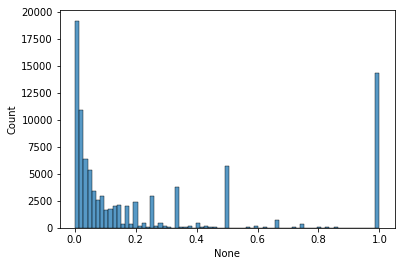

In [36]:
conds = [cond_p(w1, w2) for w1 in hierarch_voc.keys() for w2 in hierarch_voc[w1].keys()]
sns.histplot(conds)

In [35]:
[cond_p(w1, w2) for w1 in list(hierarch_voc.keys())[573:574] for w2 in hierarch_voc[w1].keys()]

[1.0]

In [38]:
from collections import Counter

Counter(conds)

Counter({0.07692307692307693: 1023,
         0.46153846153846156: 28,
         0.2857142857142857: 384,
         0.14285714285714285: 1990,
         1.0: 14373,
         0.2: 2380,
         0.4: 438,
         0.16666666666666666: 1888,
         0.5: 5703,
         0.6666666666666666: 704,
         0.3333333333333333: 3740,
         0.6: 176,
         0.1: 1255,
         0.029411764705882353: 575,
         0.014705882352941176: 250,
         0.10294117647058823: 2,
         0.04411764705882353: 30,
         0.058823529411764705: 873,
         0.27586206896551724: 3,
         0.20689655172413793: 7,
         0.06896551724137931: 93,
         0.034482758620689655: 425,
         0.10344827586206896: 32,
         0.25: 2904,
         0.125: 1666,
         0.024390243902439025: 290,
         0.04878048780487805: 87,
         0.07317073170731707: 37,
         0.0975609756097561: 7,
         0.6190476190476191: 3,
         0.047619047619047616: 746,
         0.23809523809523808: 14,
         0

In [44]:
for w1, ws in tqdm(hierarch_voc.items()):
    for w2 in ws:
        if cond_p(w1, w2) < p(w2):
            print(w1, w2, p(w1), p(w2), cond_p(w1, w2)) #, cond_p(w2, w1))
            print()

 10%|█         | 2636/25417 [00:22<07:01, 54.08it/s] 

beeld werden 0.001943977557526782 0.004958638139045238 0.003076923076923077



 25%|██▌       | 6478/25417 [00:57<02:51, 110.41it/s]

elkaar gebruikt 0.0014056453108270577 0.00439039854530664 0.00425531914893617

elkaar gemaakt 0.0014056453108270577 0.004378435606491091 0.00425531914893617



 28%|██▊       | 7047/25417 [01:01<01:47, 170.87it/s]

figuren gebruikt 0.0017465890670702166 0.00439039854530664 0.003424657534246575



 28%|██▊       | 7227/25417 [01:04<04:04, 74.41it/s] 

foto werden 0.002045662537458952 0.004958638139045238 0.0029239766081871343



 30%|██▉       | 7557/25417 [01:08<06:44, 44.17it/s] 

gebruikt gebruikt 0.00439039854530664 0.00439039854530664 0.0013623978201634877

gebruikt gemaakt 0.00439039854530664 0.004378435606491091 0.0027247956403269754

gebruikt java 0.00439039854530664 0.0015192932295747773 0.0013623978201634877

gebruikt onderdeel 0.00439039854530664 0.001591070862468074 0.0013623978201634877



 31%|███       | 7919/25417 [01:13<02:01, 144.10it/s]

gemaakt elkaar 0.004378435606491091 0.0014056453108270577 0.001366120218579235

gemaakt foto 0.004378435606491091 0.002045662537458952 0.001366120218579235

gemaakt man 0.004378435606491091 0.00219519927265332 0.001366120218579235

gemaakt midden 0.004378435606491091 0.0015372376377981016 0.001366120218579235



 31%|███       | 7935/25417 [01:14<06:18, 46.25it/s] 

gemaakt tussen 0.004378435606491091 0.0016807929035846947 0.001366120218579235



 39%|███▉      | 9900/25417 [01:34<03:31, 73.53it/s] 

hout twee 0.0017645334752935406 0.00395973274794686 0.003389830508474576

hout werden 0.0017645334752935406 0.004958638139045238 0.003389830508474576



 39%|███▉      | 9922/25417 [01:35<06:48, 37.96it/s]

houten vorm 0.0027754018052074674 0.0022071622114688693 0.0021551724137931034



 53%|█████▎    | 13404/25417 [02:05<01:48, 110.71it/s]

man gebruikt 0.00219519927265332 0.00439039854530664 0.0027247956403269754



 53%|█████▎    | 13510/25417 [02:07<02:53, 68.63it/s] 

mannen werden 0.001967903435157881 0.004958638139045238 0.00303951367781155



 55%|█████▌    | 13992/25417 [02:12<02:31, 75.40it/s] 

midden twee 0.0015372376377981016 0.00395973274794686 0.0038910505836575876



 66%|██████▌   | 16812/25417 [02:38<00:57, 149.51it/s]

pijl gebruikt 0.001381719433195959 0.00439039854530664 0.004329004329004329



 84%|████████▎ | 21229/25417 [03:12<00:28, 145.00it/s]

the and 0.006142969081784631 0.002661753886459748 0.0009737098344693282



 84%|████████▍ | 21332/25417 [03:14<00:54, 75.47it/s] 

tijdens grote 0.0026677353558675226 0.002464365396003182 0.002242152466367713



 86%|████████▋ | 21957/25417 [03:21<01:10, 48.73it/s] 

twee zwart 0.00395973274794686 0.0019140702104879085 0.0015105740181268882



 88%|████████▊ | 22318/25417 [03:23<00:15, 203.79it/s]

vaak gemaakt 0.002069588415090051 0.004378435606491091 0.002890173410404624

vaak twee 0.002069588415090051 0.00395973274794686 0.002890173410404624



 96%|█████████▌| 24367/25417 [03:46<00:12, 85.44it/s] 

werden elkaar 0.004958638139045238 0.0014056453108270577 0.0012062726176115801

werden houten 0.004958638139045238 0.0027754018052074674 0.0012062726176115801

werden rond 0.004958638139045238 0.0012082568203704922 0.0012062726176115801

werden tijdens 0.004958638139045238 0.0026677353558675226 0.0012062726176115801

werden twee 0.004958638139045238 0.00395973274794686 0.0012062726176115801

werden versierd 0.004958638139045238 0.0019738849045656554 0.0012062726176115801

werden wit 0.004958638139045238 0.002338754538439913 0.0012062726176115801

werden zwart 0.004958638139045238 0.0019140702104879085 0.0012062726176115801



100%|█████████▉| 25332/25417 [03:56<00:01, 74.26it/s] 

zwart gebruikt 0.0019140702104879085 0.00439039854530664 0.003125

zwart twee 0.0019140702104879085 0.00395973274794686 0.003125



100%|██████████| 25417/25417 [03:57<00:00, 107.04it/s]


## Compute PMI Values

In [ ]:
def pmi(w1, w2):
    return np.log2(cond_p(w1, w2)) - np.log2(p(w2))

pmis = {w1: {w2: pmi(w1, w2) for w2 in hierarch_voc[w1].keys()} for w1 in tqdm(hierarch_voc.keys())}

In [ ]:
pmis

In [ ]:
# def cond_p(w1, w2):
#     bi_f = bi_freqs[(w1, w2)]
#     try:
#         uni_f = uni_freqs[w1]
#         return bi_f/uni_f
#     except KeyError:
#         raise

# def pmi(w1, w2):
#     return cond_p(w1, w2),  np.log2(p(w2))

w1 = "europa"

sorted({w2: pmi(w1, w2) for w2 in hierarch_voc[w1].keys()}.items(), key=lambda t:t[1])

In [ ]:
collocations = [(pmi, w1, w2) for w1 in pmis.keys() for w2, pmi in pmis[w1].items() if 3.0 < pmi < 5.0]

collocations

### Stopwords

In [ ]:
import nltk
stopwords = nltk.corpus.stopwords.words('dutch')

In [ ]:
uv = unigram_cv.vocabulary_

set(stopwords) & set(uv.keys())

### Document Frequencies

In [ ]:
types = set(tokens)


dfs = {w: len([txt for txt in all_txts if w in txt]) for w in tqdm(types)}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(len(dfs))


sns.distplot([d for d in dfs.values() if d < 500])
# plt.xlim((0, 1000))

In [ ]:
500/len(all_txts)

In [ ]:
low_df_stopwords = [w for w, df in dfs.items() if w in stopwords and df < 1000]
high_df_stopwords = [w for w, df in dfs.items() if w in stopwords and df > 1000]

In [ ]:
high_df_stopwords